In [1]:
from helper import *
from word_embeddings import *
from gensim.models import Word2Vec
import numpy as np

In [2]:
#df = transcripts_to_df("test_transcripts")
#"2018" in df["year"].tolist()

In [3]:
#Create embeddings
df = transcripts_to_df("test_transcripts")
#df = df.loc[df["year"] == "2010"]
#df = df.head(10)
preprocess_df(df)
#models = []
#for year in ["2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2016", "2017", "2019", "2020"]:
    #m = create_word_embeddings(df.loc[df["year"] == year].reset_index(drop=True))
    #m.save("w2v_{}.model".format(year))
#    models.append(Word2Vec.load("w2v_{}.model".format(year)))

In [4]:
df.head()

,transcriptionName,content,year,month,day
0,tagesschau_04012013_2000_.wav.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,01,04
1,tagesschau_02042013_2000_.wav.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,04,02
2,tagesschau_27092013_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,09,27
3,tagesschau_20112013_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,11,20
4,tagesschau_12012013_2000_.wav.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2013,01,12


In [5]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        (With help from William. Thank you!)

    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.

    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    
    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    models = align_gensim_models([base_embed, other_embed], words=words)
    in_base_embed = models[0]
    in_other_embed = models[1]

    # get the embedding matrices
    base_vecs = in_base_embed.wv.syn0norm
    other_vecs = in_other_embed.wv.syn0norm

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors_norm = other_embed.wv.syn0 = (other_embed.wv.vectors_norm).dot(ortho)
    return other_embed

In [6]:
# Code originally ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.

def align_gensim_models(models, words=None):
    """
    Returns the aligned/intersected models from a list of gensim word2vec models.
    Generalized from original two-way intersection as seen above.
    
    Also updated to work with the most recent version of gensim
    Requires reduce from functools
    
    In order to run this, make sure you run 'model.init_sims()' for each model before you input them for alignment.
    
    ##############################################
    ORIGINAL DESCRIPTION
    ##############################################
    
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocabs = [set(m.wv.vocab.keys()) for m in models]

    # Find the common vocabulary
    common_vocab = reduce((lambda vocab1,vocab2: vocab1&vocab2), vocabs)
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    
    # This was generalized from:
    # if not vocab_m1-common_vocab and not vocab_m2-common_vocab and not vocab_m3-common_vocab:
    #   return (m1,m2,m3)
    if all(not vocab-common_vocab for vocab in vocabs):
        print("All identical!")
        return models
        
    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: sum([m.wv.vocab[w].count for m in models]),reverse=True)
    
    # Then for each model...
    for m in models:
        
        # Replace old vectors_norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
                
        old_arr = m.wv.vectors_norm
                
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors_norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return models

In [7]:
from functools import reduce
import gensim
#for m in models:
#    m.init_sims()
#aligned_models = align_gensim_models(models)
#for m in models:
#    print(m.most_similar("putin"))
selected_models = []
models.reverse()
selected_models.append(models[0])
for i in range(1,5):
    m_aligned = smart_procrustes_align_gensim(selected_models[i-1], models[i+3])
    selected_models.append(m_aligned)
selected_models

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).


In [8]:
selected_models

In [12]:
def drawArrow(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=0.02, length_includes_head=True, color="red", alpha=0.5, linewidth=2)
    
#plot2(selected_models, ["deutschland", "frankreich", "griechenland"], "test", ["2008", "2011", "2014", "2017", "2020"], 2)

In [13]:
def tsne_plot(models, keys, years, context_len):
    "Creates and TSNE model and plots it"
    plt.figure(figsize=(16, 16))
    labels = []
    tokens = []
    for model in models:
        for word in keys:
            tokens.append(model[word])
            labels.append(word)
            for similar_word, _ in model.most_similar(word, topn=context_len):
                labels.append(similar_word)
                tokens.append(model[similar_word])

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    colors = cm.rainbow(np.linspace(0, 1, len(models)))
    old_coords = {key: None for key in keys}
    for i, model in enumerate(models):
        x = new_values[(len(keys)+context_len)*i: (len(keys)+context_len)*i+len(keys)*context_len+len(keys), 0]
        y = new_values[(len(keys)+context_len)*i: (len(keys)+context_len)*i+len(keys)*context_len+len(keys), 1]
        words_iteration = labels[(len(keys)+context_len)*i: (len(keys)+context_len)*i+len(keys)*context_len+len(keys)]
        print(words_iteration)
        plt.scatter(x, y, c=colors[i], alpha=0.7, label=years[i], s=35)
        for j, word in enumerate(words_iteration):
            if j%(context_len+1) == 0:
                alpha=1.0
                if old_coords[word] is None:
                    old_coords[word] = (x[j], y[j])
                else:
                    new_coords = (x[j], y[j])
                    drawArrow(old_coords[word], new_coords)
                    old_coords[word] = new_coords
            else:
                alpha=0.3
            plt.annotate(word,
                             xy=(x[j], y[j]),
                             xytext=(5, 2),
                             textcoords='offset points',
                             ha='right',
                             va='bottom',size=13, alpha=alpha)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show() 

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numer

['polizei', 'beamte', 'demonstrant', 'kundgebung', 'polizist', 'tränengas', 'zusammenstoß', 'demonstration', 'mehrer', 'gruppe', 'netzwerk']
['polizei', 'tränengas', 'demonstrant', 'auseinandersetzung', 'polizist', 'beamte', 'innenstadt', 'gewaltsam', 'sicherheitskräften', 'verhaften', 'festnehmen']
['polizei', 'tränengas', 'sicherheitskräften', 'demonstrant', 'festnehmen', 'zahlreiche', 'mehrer', 'zusammenstoß', 'auseinandersetzung', 'gewalttätig', 'sicherheitskräfte']
['polizei', 'tränengas', 'innenministerium', 'verhaften', 'wohnung', 'helfer', 'vernichten', 'täter', 'zusammenstoß', 'auslöser', 'demonstrant']
['polizei', 'gewalttätig', 'zusammenstoß', 'polizist', 'tränengas', 'auseinandersetzung', 'festnehmen', 'verhaften', 'durchsuchen', 'ausschreitung', 'demonstrant']


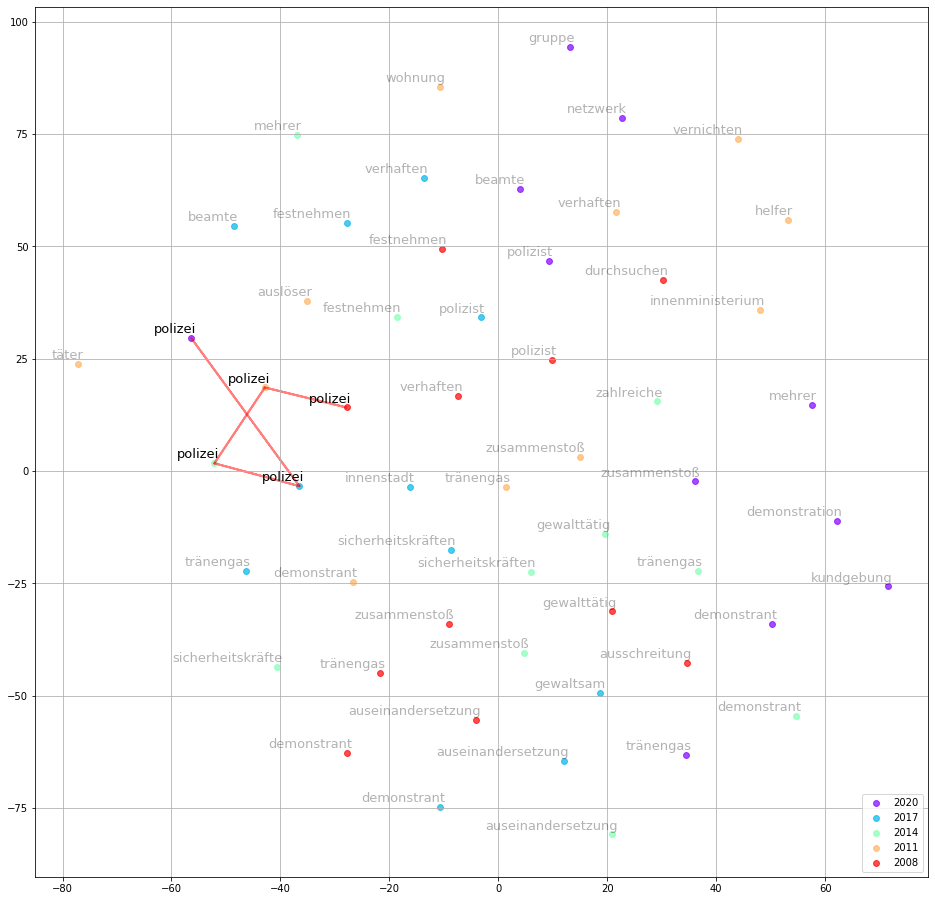

In [101]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
years = ["2008", "2011", "2014", "2017", "2020"]
years.reverse()
tsne_plot(selected_models, ["polizei"], years, 10)

In [165]:
from sklearn.metrics.pairwise import cosine_similarity
sim_dict = {}
i = 0
for word in m_2010.wv.vocab:
    sim = cosine_similarity(m_2010[word].reshape(1, -1), m_2015[word].reshape(1, -1))[0,0]
    sim_dict[word] = sim
    i += 1

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem_

Old code:

In [9]:
def plot(model, keys, title):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in model.most_similar(word, topn=5):
            words.append(similar_word)
            embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    from sklearn.manifold import TSNE
    import numpy as np

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    %matplotlib inline


    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(keys)))
    for label, embeddings, words, color in zip(keys, embeddings_en_2d, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label, s=30)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [10]:
import matplotlib.pyplot as plt

def plot2(models, keys, title, years, num_context):
    embedding_clusters = []
    word_clusters = []
    i = 0
    for m in models:
        embeddings = []
        words = []
        for key in keys:
            embeddings.append(m[key])
            words.append(key)
            for similar_word, _ in m.most_similar(key, topn=num_context):
                words.append(similar_word)
                embeddings.append(m[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    from sklearn.manifold import TSNE
    import numpy as np

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=42)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    %matplotlib inline


    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(models)))
    old_coords = {key: None for key in keys}
    for year, embeddings, words, color in zip(years, embeddings_en_2d, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=year, s=35)
        for i, word in enumerate(words):
            if word in keys:
                plt.annotate(word, alpha=0.9,xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=14)
                if old_coords[word] is None:
                    old_coords[word] = (x[i], y[i])
                else:
                    new_coords = (x[i], y[i])
                    drawArrow(old_coords[word], new_coords)
                    old_coords[word] = new_coords
            else:
                plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show() 